<a href="https://colab.research.google.com/github/abdala9512/nlp-evaluacion-problemas-sociales/blob/main/DataPreparation_(OneHotEncoding).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**
### One Hot Encoding Transformation

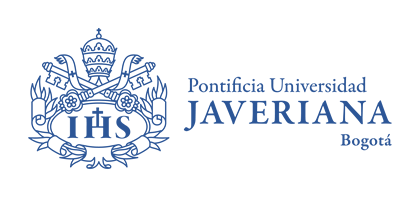

#### **Integrantes:**
- Omar Balcero
- Miguel Arquez
- Leonardo Espitia
- Laura Peñaranda

# Library Reading

In [1]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from google.colab import drive
from scipy.stats import kurtosis
from scipy.stats import skew
import matplotlib.pyplot as plt
import nltk
import pdb
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import unidecode
import string
from sklearn.feature_extraction.text import CountVectorizer
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Reading

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/PNL202202/Proyecto Final/ArchivoProblemas (1).csv', delimiter=';')
df = df.assign(DESCRIPCION_LEM = df['DESCRIPCION_LEM'].fillna(df['Unnamed: 4'].apply(lambda x: np.nan if pd.isna(x) else '[' + x + ']')))
df = df.loc[df['DESCRIPCION_LEM'].isna()==False, ['TIPO','ID','DESCRIPCION','DESCRIPCION_LEM']]

stopwords_spanish = stopwords.words('spanish')
puntuacion = string.punctuation + '¿¡(“”‘’…'

In [5]:
df['descripcionlem'] = df['DESCRIPCION_LEM']\
.str.replace('[','').str.replace(']','').str.replace("'",'').str.replace(',','').str.replace('  ',' ')\
.str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')\
.str.replace(r'[0-9]','')

df['descripcionlem'] = [x.split(' ') for x in df['descripcionlem']]
df['descripcionlem'] = df['descripcionlem'].apply(lambda y: [x for x in y if (x in puntuacion)==False])
df['descripcionlem_sp'] = df['descripcionlem'].apply(lambda y: [x for x in y if (x in stopwords_spanish)==False])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([' '.join(x) for x in df['descripcionlem']])
X_fn = vectorizer.get_feature_names_out()
X = X.toarray()

df1 = pd.DataFrame(X, columns = X_fn).merge( df['TIPO'], how = 'left', left_index=True, right_index=True)

vectorizer_sp = CountVectorizer()
X2 = vectorizer_sp.fit_transform([' '.join(x) for x in df['descripcionlem_sp']])
X2_fn = vectorizer_sp.get_feature_names_out()
X2 = X2.toarray()

df2 = pd.DataFrame(X, columns = X_fn).merge( df['TIPO'], how = 'left', left_index=True, right_index=True)

# Visualization

## **PCA**

In [119]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)

PCA_X = pca.transform(X)

[0.37540629 0.07578001]


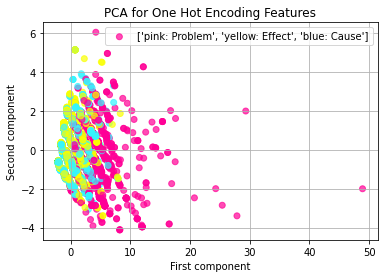

In [138]:
colors = df['TIPO'].apply(lambda x: '#ff0096' if x == 'Problem' else ('#faff00' if x == 'Effect' else '#35f5ff'))

plt.scatter(PCA_X[:,0], PCA_X[:,1], c = colors, alpha = 0.7, label = ['pink: Problem', 'yellow: Effect', 'blue: Cause'])
plt.title('PCA for One Hot Encoding Features')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend()
plt.grid()
plt.show()

[0.05767432 0.03761015]


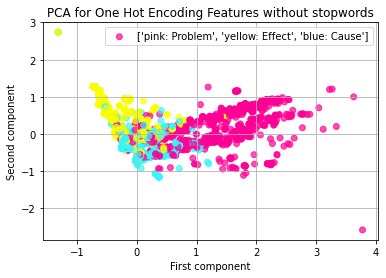

In [141]:
pca2 = PCA(n_components=2)
pca2.fit(X2)
print(pca2.explained_variance_ratio_)

PCA_X2 = pca2.transform(X2)

plt.scatter(PCA_X2[:,0], PCA_X2[:,1], c = colors, alpha = 0.7, label = ['pink: Problem', 'yellow: Effect', 'blue: Cause'])
plt.title('PCA for One Hot Encoding Features without stopwords')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend()
plt.grid()
plt.show()

## UMAP

In [7]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    # Create a Pandas dataframe using the above array
    df=pd.DataFrame(X, columns=['x', 'y', 'z'])
    df['label'] = y
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)
    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    fig.show()

In [8]:
from umap import UMAP

reducer = UMAP(n_components=3,
               metric='euclidean')

# Fit and transform the data
X_trans = reducer.fit_transform(X)

chart(X_trans, df['TIPO'])

ImportError: ignored